In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

from jaxtyping import Float
from distributions.chess import ChessDataset
from distributions.gaussian import GaussianDistribution

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [4]:
class FourierEmbedding(nn.Module):
    def __init__(self, num_freqs: int = 6, channels: int = 2):
        super().__init__()
        self.num_freqs = num_freqs
        self.channels = channels
        self.out_dim = 2 * num_freqs * channels
        
        freq_bands = 2.0 ** torch.linspace(0, num_freqs-1, num_freqs)
        self.register_buffer('freq_bands', freq_bands)
    
    def forward(self, X):
        result = []

        for freq in self.freq_bands:
            for c in range(self.channels):
                result.append(torch.sin(X[:, c] * freq * torch.pi).unsqueeze(-1))
                result.append(torch.cos(X[:, c] * freq * torch.pi).unsqueeze(-1))
        
        return torch.cat(result, dim=-1)

In [5]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        in_features: int,
        time_freq: int = 4,
        feature_freq: int = 10,
        hidden_layers: int = 8,
        hidden_features: int = 512,
        activation: str = "ReLU",
        bias: bool = True,
    ):
        assert activation in [
            "ReLU",
            "Tanh",
            "GELU",
            "SiLU",
            "Mish",
        ], "Inappropriate activation function chosen."

        super().__init__()
        self.in_features = in_features
        self.out_features = in_features
        self.hidden_layers = hidden_layers
        self.hidden_features = hidden_features
        self.activation = activation
        self.bias = bias

        self.feature_embed = FourierEmbedding(num_freqs=feature_freq, channels=self.in_features)
        self.time_embed = FourierEmbedding(num_freqs=time_freq, channels=1)
        self.net = self.initialize_net()

    def initialize_net(self):
        net = []

        net.extend(
            [
                nn.Linear(
                    in_features=self.feature_embed.out_dim + self.time_embed.out_dim,
                    out_features=self.hidden_features,
                    bias=self.bias,
                ),
                nn.BatchNorm1d(self.hidden_features),
                getattr(nn, self.activation)(),
            ]
        )

        for i in range(self.hidden_layers):
            net.extend(
                [
                    nn.Linear(
                        in_features=self.hidden_features,
                        out_features=self.hidden_features,
                        bias=self.bias,
                    ),
                    nn.BatchNorm1d(self.hidden_features),
                    getattr(nn, self.activation)(),
                    nn.Dropout(p=0.1 + 0.015 * i),
                ]
            )

        net.extend(
            [
                nn.Linear(
                    in_features=self.hidden_features,
                    out_features=self.hidden_features // 2,
                    bias=self.bias,
                ),
                getattr(nn, self.activation)(),
                nn.Linear(
                    in_features=self.hidden_features // 2,
                    out_features=self.out_features,
                    bias=self.bias,
                ),
            ]
        )

        return nn.Sequential(*net)

    def forward(
        self,
        X: Float[torch.Tensor, "*batch dim"],
        T: Float[torch.Tensor, "*batch 1"],
    ) -> Float[torch.Tensor, "*batch dim"]:
        X_embed = self.feature_embed(X)
        T_embed = self.time_embed(T)
        return self.net(torch.cat((X_embed, T_embed), dim=-1))

In [6]:
def training(
    model: FlowMatching,
    dataset_size: int = 2**14,
    batch_size: int = 64,
    lr: float = 1e-4,
    epochs: int = 10,
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    gaussian = GaussianDistribution(
        mean=torch.tensor([0, 0], dtype=torch.float32),
        std=torch.tensor([1, 1], dtype=torch.float32),
    )

    training_set = ChessDataset(
        size=dataset_size, batch_size=batch_size, num_squares=4, num_range=4.0
    )
    validation_set = ChessDataset(
        size=2048, batch_size=256, num_squares=4, num_range=4.0
    )

    losses = []
    for e in range(epochs):
        model.train()
        for i in range(dataset_size // batch_size):
            Z = training_set.get_batch(i)
            T = torch.rand(batch_size).unsqueeze(-1)
            epsilon = gaussian.sample(batch_size)

            X = T * Z + (1 - T) * epsilon
            target = Z - epsilon

            out = model(X, T)
            loss = torch.nn.functional.mse_loss(out, target)

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for i in range(8):
                Z = validation_set.get_batch(i)
                T = torch.rand(256).unsqueeze(-1)
                epsilon = gaussian.sample(256)

                X = T * Z + (1 - T) * epsilon
                target = Z - epsilon

                out = model(X, T)
                loss = torch.nn.functional.mse_loss(out, target)
                total_loss += loss.item()

        losses.append(total_loss)
        print(f"Epoch {e}; : validation loss={total_loss / 8.0:.4f}")
        
    return losses

Total Model Parameters: ~8.0mil
Epoch 0; : validation loss=2.2774
Epoch 1; : validation loss=2.3075
Epoch 2; : validation loss=2.3352
Epoch 3; : validation loss=2.2567
Epoch 4; : validation loss=2.3251
Epoch 5; : validation loss=2.3200
Epoch 6; : validation loss=2.3220
Epoch 7; : validation loss=2.2549
Epoch 8; : validation loss=2.2494
Epoch 9; : validation loss=2.2525
Epoch 10; : validation loss=2.2669
Epoch 11; : validation loss=2.1773
Epoch 12; : validation loss=2.2327
Epoch 13; : validation loss=2.2727
Epoch 14; : validation loss=2.1848
Epoch 15; : validation loss=2.2221
Epoch 16; : validation loss=2.1833
Epoch 17; : validation loss=2.2311
Epoch 18; : validation loss=2.2130
Epoch 19; : validation loss=2.1755
Epoch 20; : validation loss=2.1737
Epoch 21; : validation loss=2.2042
Epoch 22; : validation loss=2.2330
Epoch 23; : validation loss=2.2054
Epoch 24; : validation loss=2.1847
Epoch 25; : validation loss=2.2147
Epoch 26; : validation loss=2.1781
Epoch 27; : validation loss=2.214

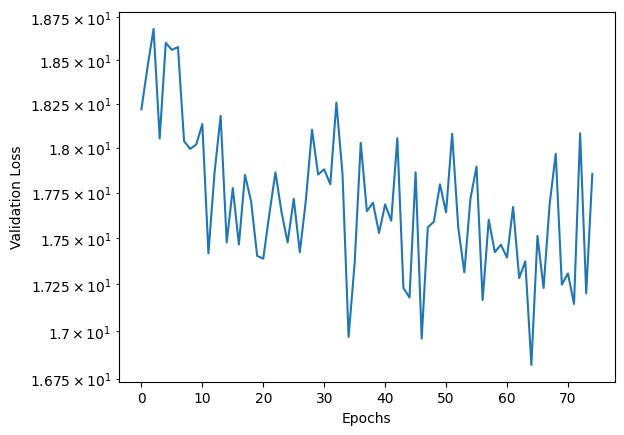

In [7]:
params = {
    "in_features": 2,
    "time_freq": 6,
    "feature_freq": 10,
    "hidden_layers": 16,
    "hidden_features": 712,
    "activation": "ReLU",
    "bias": True,
}
flow_matching_model = FlowMatching(**params).to(device=device)
print(f"Total Model Parameters: ~{sum(p.numel() for p in flow_matching_model.parameters()) // 1e6}mil")

losses = training(model=flow_matching_model, dataset_size=2**14, batch_size=256, lr=3e-4, epochs=75)
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Epochs')
ax.set_ylabel('Validation Loss')
ax.set_yscale('log')

fig.show(warn=False)

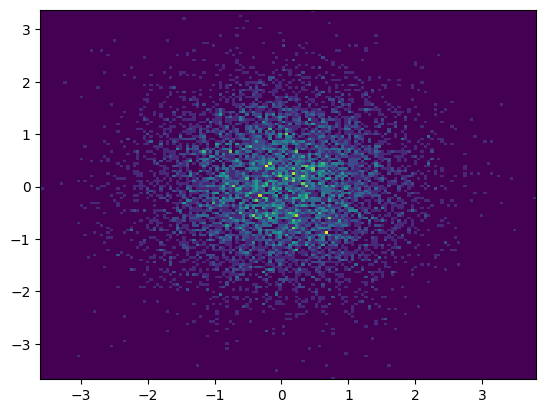

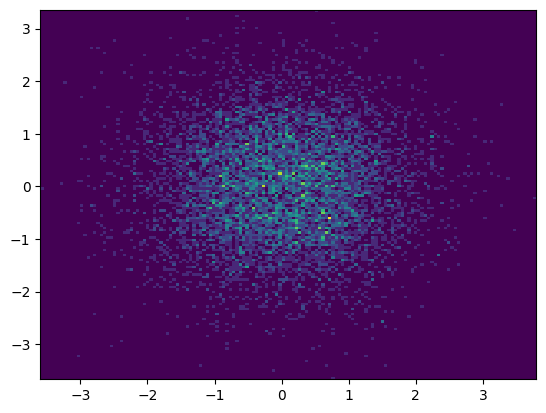

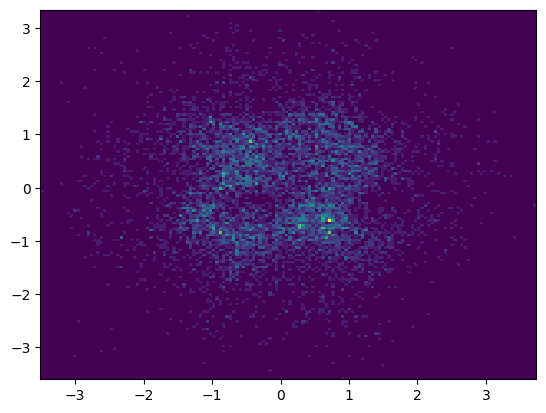

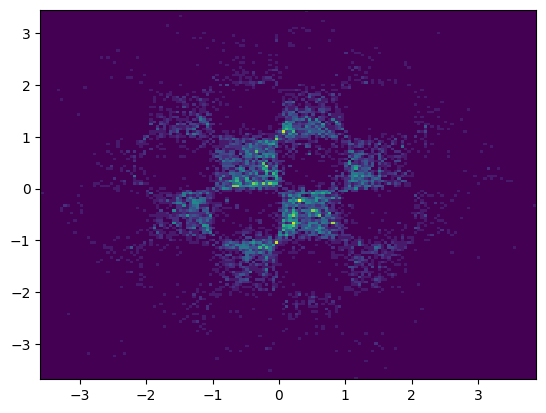

In [8]:
n_steps = 200
samples = 8000
dt = 1/n_steps

X = GaussianDistribution(
    mean=torch.tensor([0, 0], dtype=torch.float32),
    std=torch.tensor([1, 1], dtype=torch.float32),
).sample(samples)

flow_matching_model.eval()
with torch.no_grad():
    for i in range(n_steps):
        T = torch.ones(samples, 1, device=device) * (i * dt)
        U = flow_matching_model(X, T)
        
        X = X + dt * U

        if (i+1) % (n_steps//4) == 0:
            out = X.detach().cpu().numpy()
            fig, ax = plt.subplots()
            ax.hist2d(out[:, 0], out[:, 1], bins=150)
            fig.show(warn=False)

In [9]:
torch.save(flow_matching_model.state_dict(), 'outputs/flow_matching_model_v0.pt')